# U-net

In [2]:
import iris
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'iris'

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

In [2]:
files = [f'/s3/mo-uki-radar-comp/20180915{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,10)]

### Read data and reshape into groups of 3 timesteps on a 100x100 grid:

In [3]:
cubes = iris.load(files)
cube = cubes[0]/32
cube = cube[:10*(cube.shape[0]//10), 1000:3000, 1000:2000]
cube_data = cube.data
cubes = iris.load(files)
cube = cubes[0]/32
cube = cube[:10*(cube.shape[0]//10), 1000:3000, 1000:2000]
cube_data = cube.data
print(np.shape(cube_data))
split_data_1 = np.stack(np.split(cube_data, cube_data.shape[0]/4))
print(np.shape(split_data_1))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[1]/100, -2))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[2]/100, -1))
print(np.shape(split_data_1))
dataset = split_data_1.reshape(-1,4,100,100)
print(np.shape(dataset))

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


(40, 2000, 1000)
(10, 4, 2000, 1000)
(10, 20, 10, 4, 100, 100)
(2000, 4, 100, 100)


In [4]:
dataset = dataset[:,:,:96,:96]
print(np.shape(dataset))

(2000, 4, 96, 96)


Convert to torch tensors and load as training dataset

In [6]:
tensor = torch.stack([torch.Tensor(i) for i in dataset])
train_loader = utils.DataLoader(tensor, batch_size=1)

### Create validation dataset

In [7]:
files = [f'/s3/mo-uki-radar-comp/20180925{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,8)]
cubes = iris.load(files)
cube = cubes[0]/32
cube = cube[:10*(cube.shape[0]//10), 1000:3000, 1000:2000]
cube_data = cube.data
split_data_1 = np.stack(np.split(cube_data, cube_data.shape[0]/4))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[1]/100, -2))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[2]/100, -1))
dataset = split_data_1.reshape(-1,4,100,100)
print(np.shape(dataset))

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


(1000, 4, 100, 100)


In [8]:
dataset = dataset[:,:,:96,:96]
print(np.shape(dataset))

(1000, 4, 96, 96)


Convert to torch tensor:

In [9]:
tensor = torch.stack([torch.Tensor(i) for i in dataset])
val_loader = utils.DataLoader(tensor, batch_size=1)

## Set up CNN architecture

### Method from https://www.kaggle.com/witwitchayakarn/u-net-with-pytorch

(This kaggle code also references https://github.com/jaxony/unet-pytorch and https://github.com/jvanvugt/pytorch-unet)

In [ ]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [ ]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x     

In [ ]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

### My modified method - current one I'm working from

In [10]:
from torch.autograd import Variable
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => ReLU) * 2''' # from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

class down_conv(nn.Module):
    '''maxpool => (conv => relu) * 2'''
    def __init__(self, in_ch, out_ch):
        super(down_conv, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch))
        
    def forward(self, x):
        x = self.mpconv(x)
        return x
        
class up_conv(nn.Module):
    '''convT => concat => (conv => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_ch//2, in_ch//2, kernel_size=2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        #print(x1.size())
        #print(x2.size())
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        
        self.conv = double_conv(in_ch, out_ch)
    def forward(self, x):
        x = self.conv(x)
        return x
        
class UNet(nn.Module):
    
    def __init__(self):
        super(UNet, self).__init__()

        self.inc = inconv(3, 64)
        self.down1 = down_conv(64, 128)
        self.down2 = down_conv(128, 256)
        self.down3 = down_conv(256, 512)
        self.down4 = down_conv(512, 512)
        self.up4 = up_conv(1024, 256)
        self.up3 = up_conv(512, 128)
        self.up2 = up_conv(256, 64)
        self.up1 = up_conv(128, 64)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        orig = x
        #print(x.size())
        x1 = self.inc(x)
        size1 = x1.size()
        #print(x1.size())
        x2 = self.down1(x1)
        #print(x2.size())
        x3 = self.down2(x2)
        #print(x3.size())
        x4 = self.down3(x3)
        #print(x4.size())
        x5 = self.down4(x4)
        #print(x5.size())
        x = self.up4(x5, x4)
        #print(x.size())
        #print(x3.size())
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
        x = self.conv2(x)
        
        return(x)

## Create loss function

In [11]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.01):
    
    #Loss function
    loss = torch.nn.MSELoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

## Train the model

In [12]:
import time

def train_net(net, batch_size, n_epochs, learning_rate):
    
    #Print the hyperparameters of the training run:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    n_batches = len(train_loader)
    
    #Create the loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):

        start_time = time.time()
        running_loss = 0.0
        print_every = n_batches // 10
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs from training data
            inputs, labels = data[:,:3], data[:,3]
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            #print(inputs.size())
            outputs = net(inputs)
            loss_size = loss(outputs[0], labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()

            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t training loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, 
                    time.time() - start_time))
                
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for data in val_loader:

            inputs, labels = data[:,:3], data[:,3]
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs[0], labels)
            total_val_loss += val_loss_size.data.item()
            #print(val_loss_size, total_val_loss, len(val_loader))
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader))) #check this is printing what we expect
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    return(total_val_loss, len(val_loader))

In [13]:
unet = UNet()
val_loss, len_val_data = train_net(unet, batch_size=10, n_epochs=5, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 10
epochs= 5
learning_rate= 0.001
Epoch 1, 10% 	 training loss: 0.06 took: 209.84s
Epoch 1, 20% 	 training loss: 0.04 took: 203.90s
Epoch 1, 30% 	 training loss: 0.07 took: 202.91s
Epoch 1, 40% 	 training loss: 0.10 took: 254.92s
Epoch 1, 50% 	 training loss: 0.03 took: 339.81s
Epoch 1, 60% 	 training loss: 0.02 took: 345.47s
Epoch 1, 70% 	 training loss: 0.00 took: 345.30s
Epoch 1, 80% 	 training loss: 0.00 took: 338.39s
Epoch 1, 90% 	 training loss: 0.00 took: 335.72s
Validation loss = 0.00
Epoch 2, 10% 	 training loss: 0.08 took: 335.87s
Epoch 2, 20% 	 training loss: 0.04 took: 338.01s
Epoch 2, 30% 	 training loss: 0.06 took: 334.78s
Epoch 2, 40% 	 training loss: 0.07 took: 335.11s
Epoch 2, 50% 	 training loss: 0.03 took: 339.72s
Epoch 2, 60% 	 training loss: 0.02 took: 350.27s
Epoch 2, 70% 	 training loss: 0.00 took: 347.83s
Epoch 2, 80% 	 training loss: 0.00 took: 347.50s
Epoch 2, 90% 	 training loss: 0.00 took: 348.17s
Validation loss = 0.0

In [1]:
print(val_loss)

NameError: name 'val_loss' is not defined

## Plot outputs

In [14]:
def setup_plt(ax):
    ax.set_xticks(np.arange(0, 100, 10))
    ax.set_yticks(np.arange(0, 100, 10))
    plt.grid()
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    plt.setp(ax.yaxis.get_ticklabels(), visible=False)
    
def show_outputs(net, loader):
    for i, data in enumerate(loader):
        if ((i > 50) & (i < 100)):
            data = data.type('torch.FloatTensor')
            inputs, labels = data[:,:3], data[:,3]
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
        
            fig = plt.figure(figsize=(16,8))
        
            ## change to just plot those with rain in the domain ##

            for i in range(3):
                ax = fig.add_subplot(2, 4, i+1)
                cf = plt.contourf(inputs[0,i], cmap=plt.cm.Greys)
                setup_plt(ax)
                if i == 0:
                    plt.title('inputs')
            
            ax = fig.add_subplot(2, 4, 4)
            cf = plt.contourf(labels[0], cmap=plt.cm.Greys)
            setup_plt(ax)
            plt.title('truth')
            ax = fig.add_subplot(2, 4, 8)
            cf = plt.contourf(val_outputs[0, 0].detach().numpy(), cmap=plt.cm.Greys)
            setup_plt(ax)
            plt.title('model')

            plt.tight_layout()

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


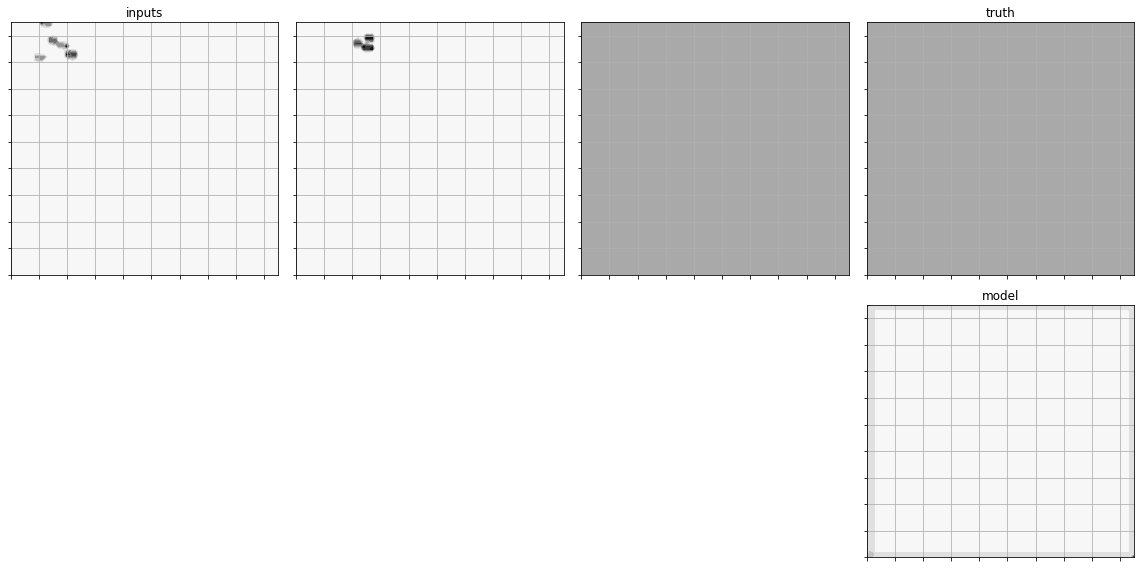

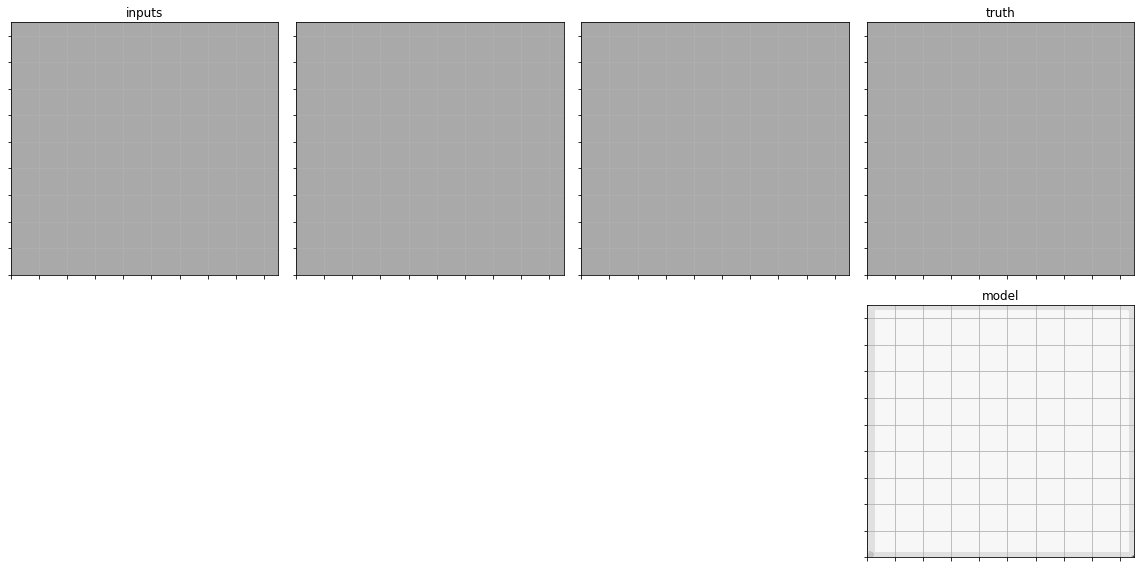

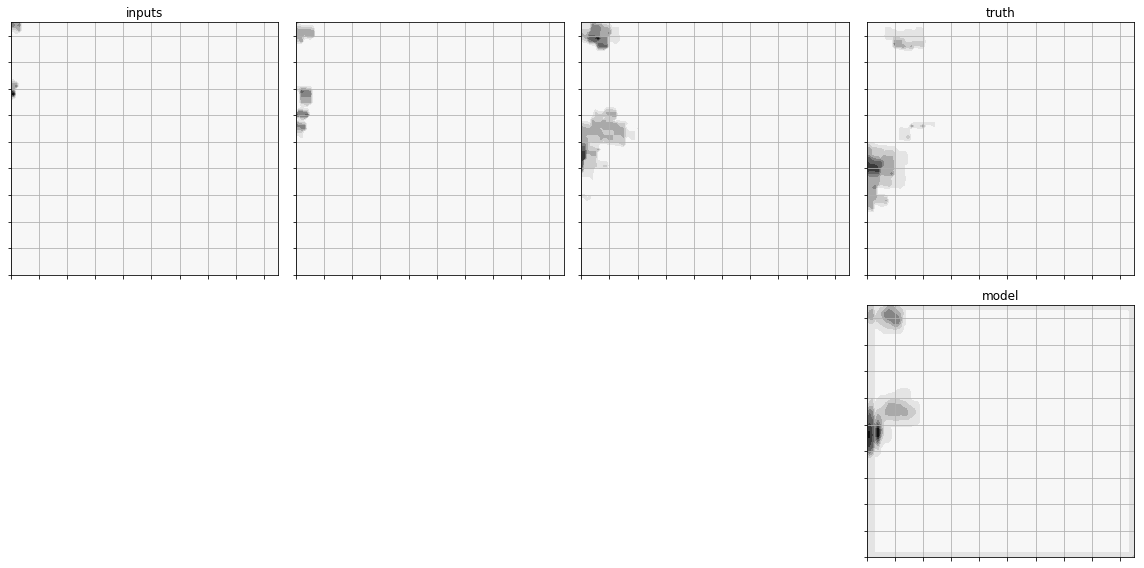

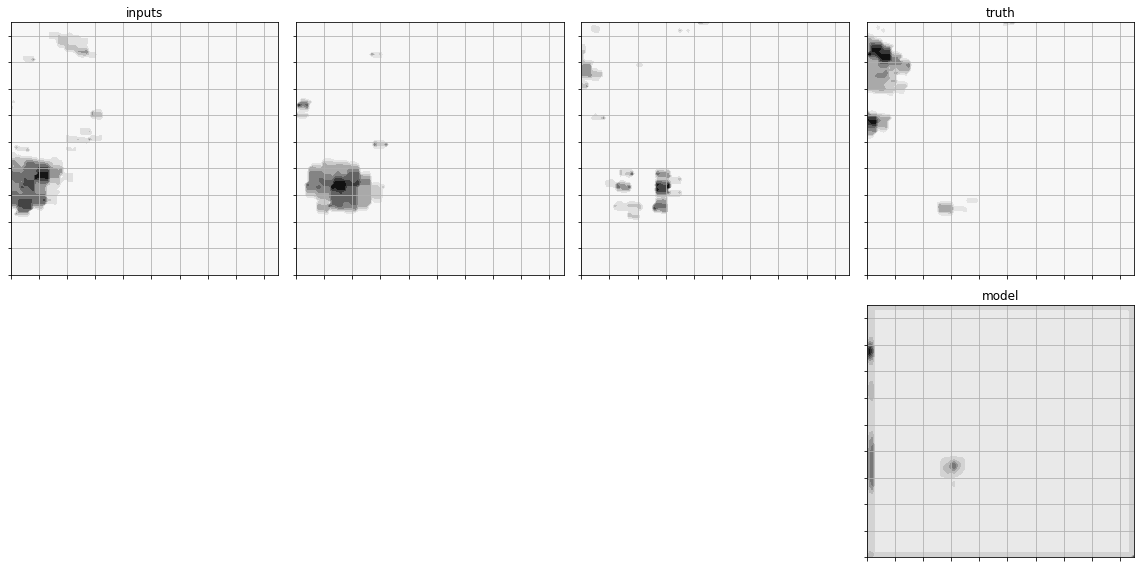

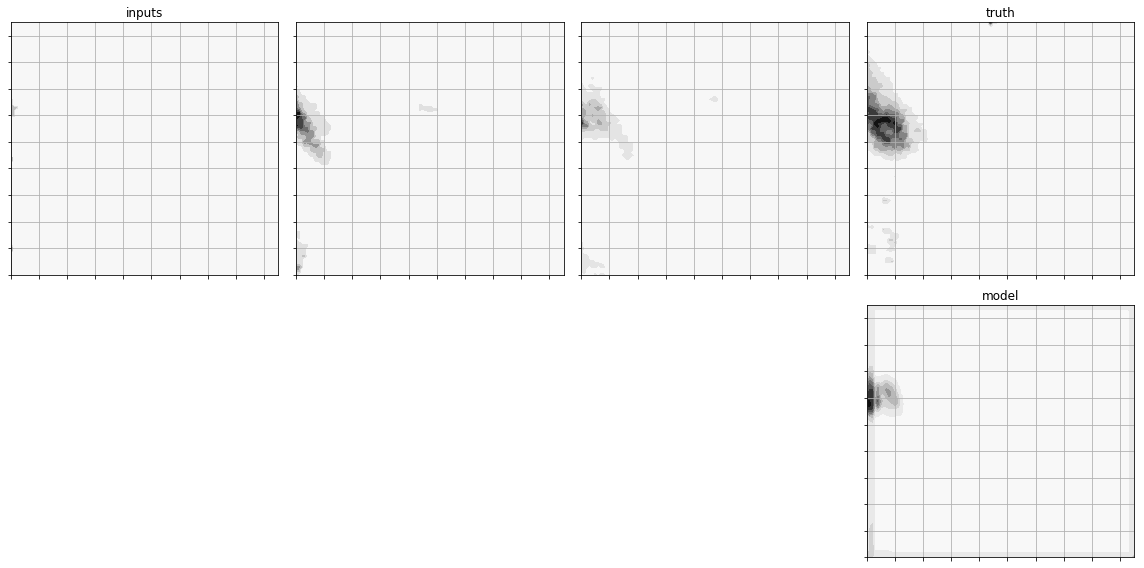

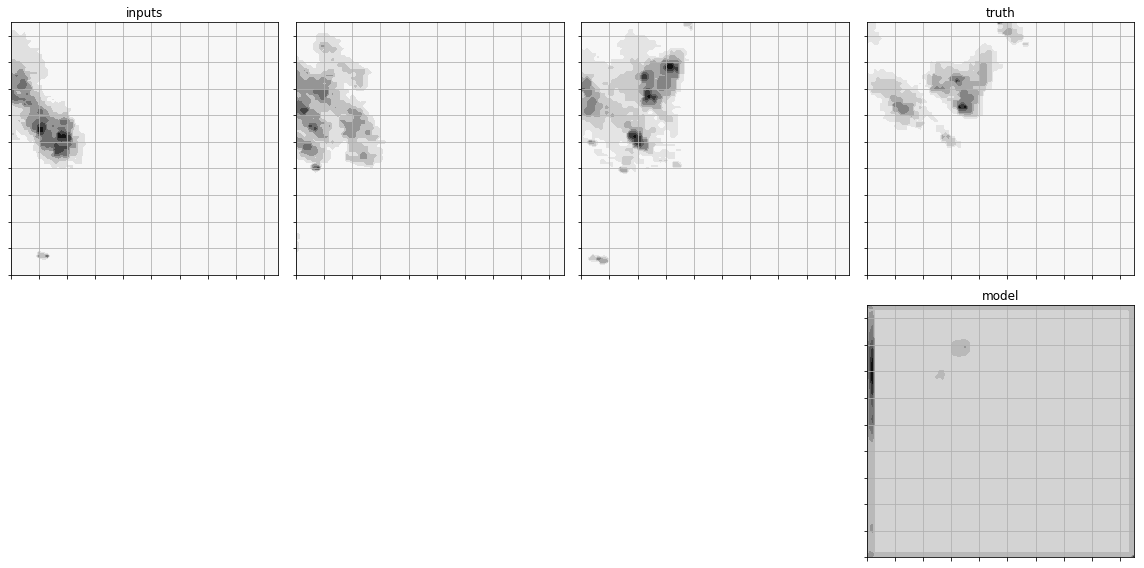

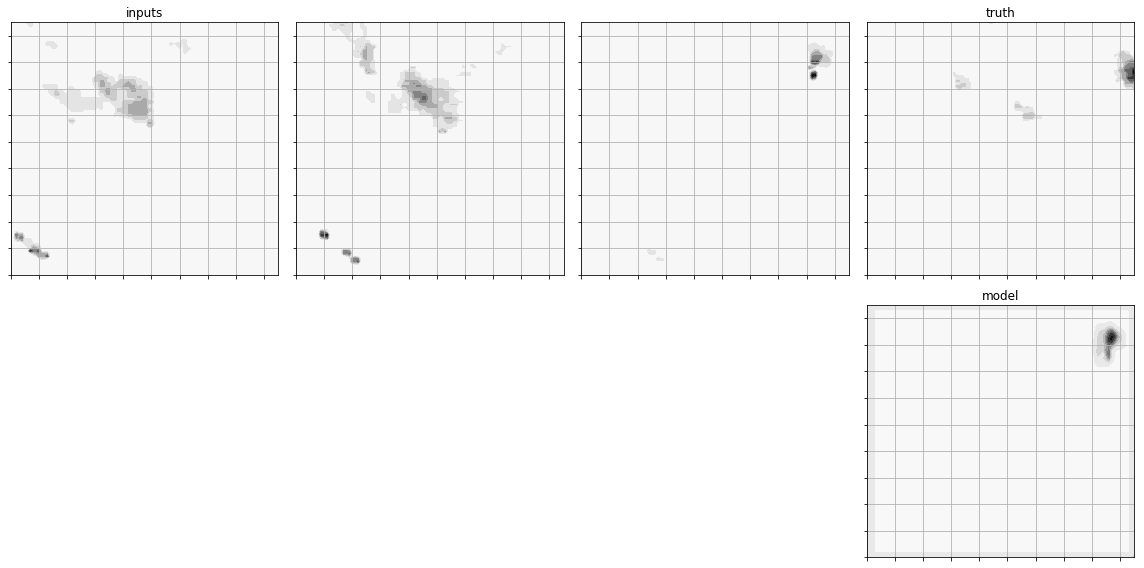

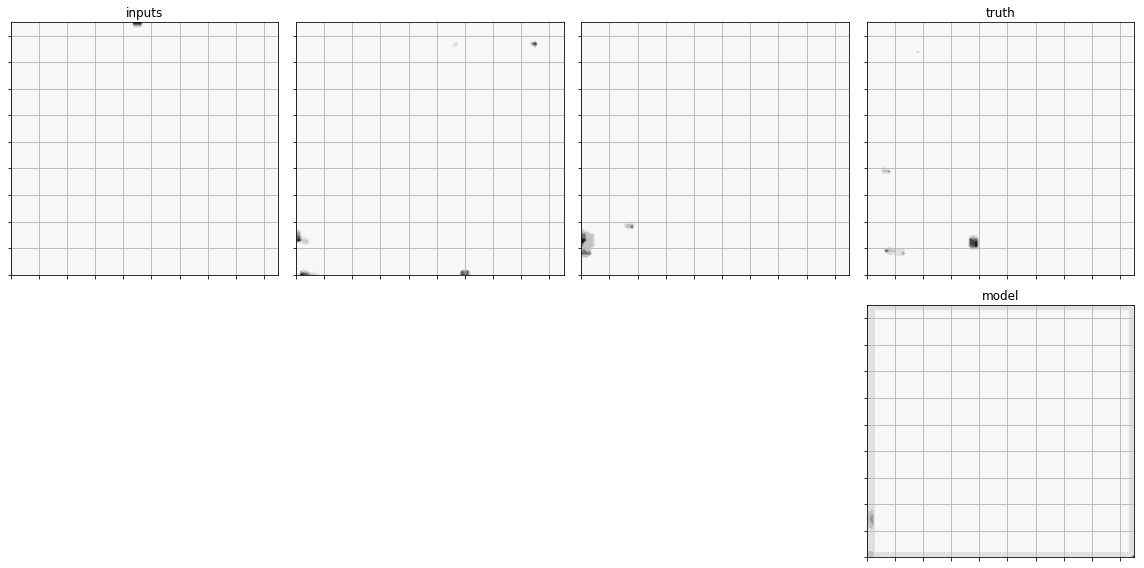

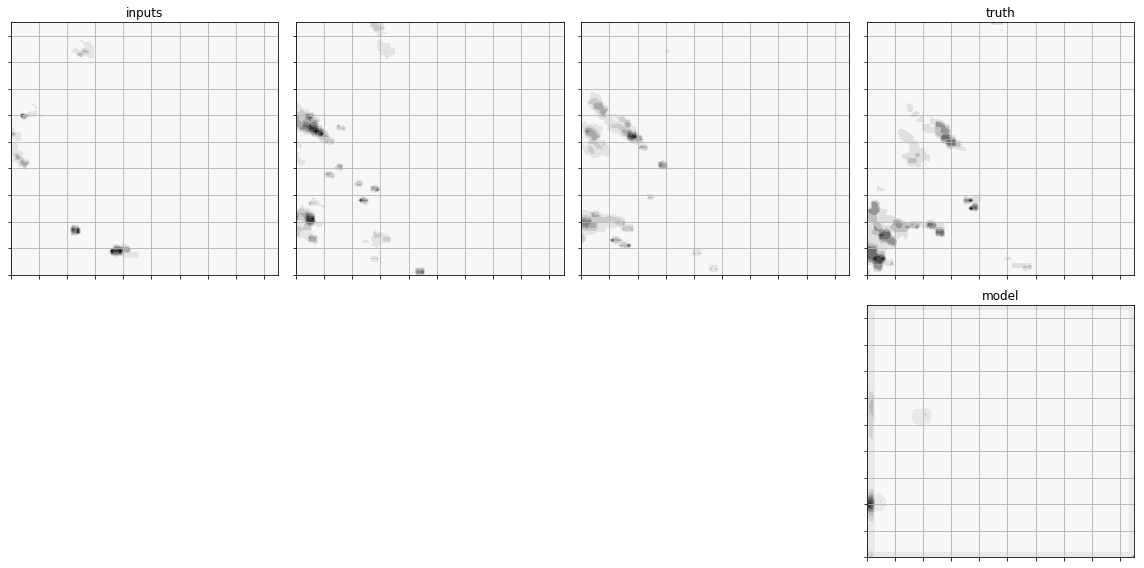

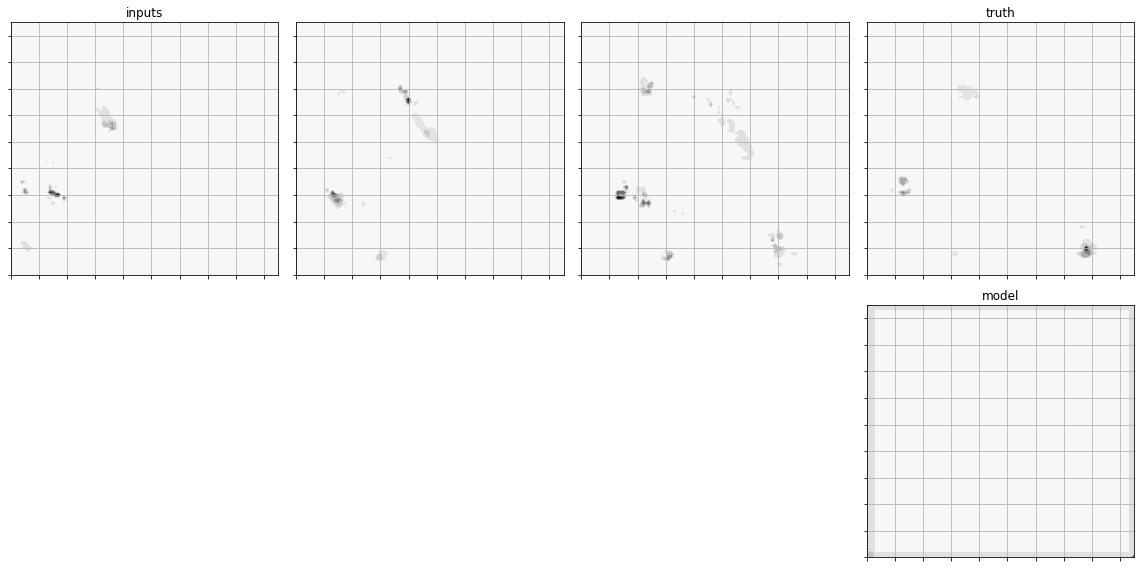

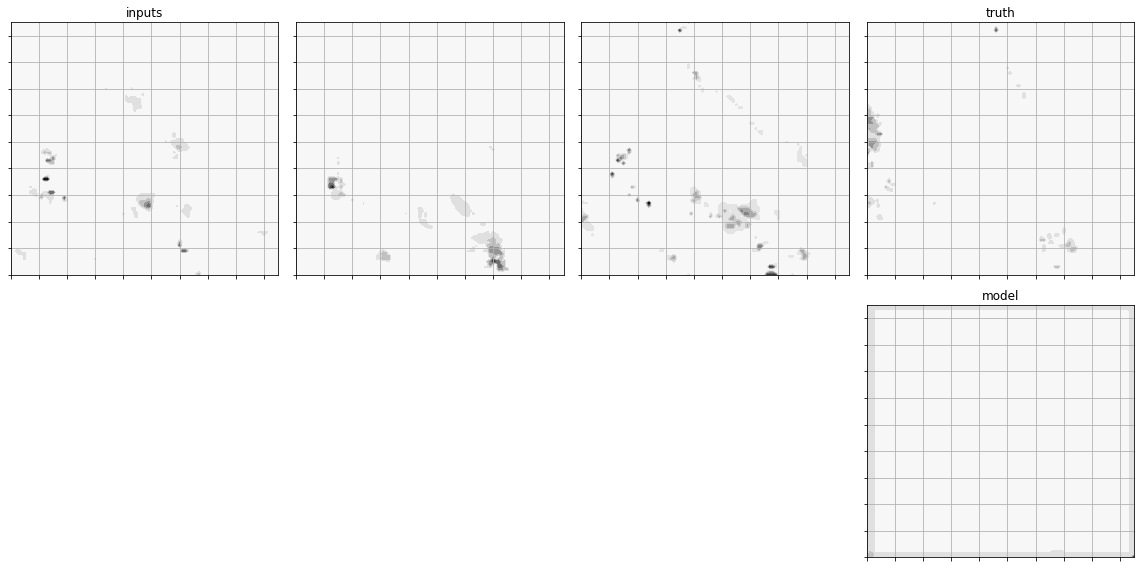

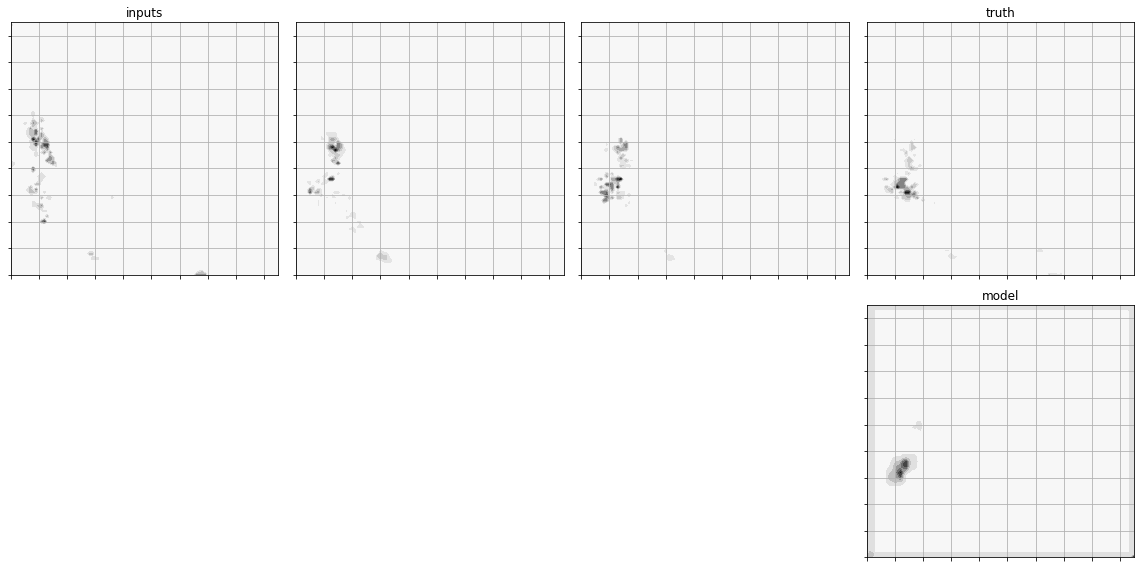

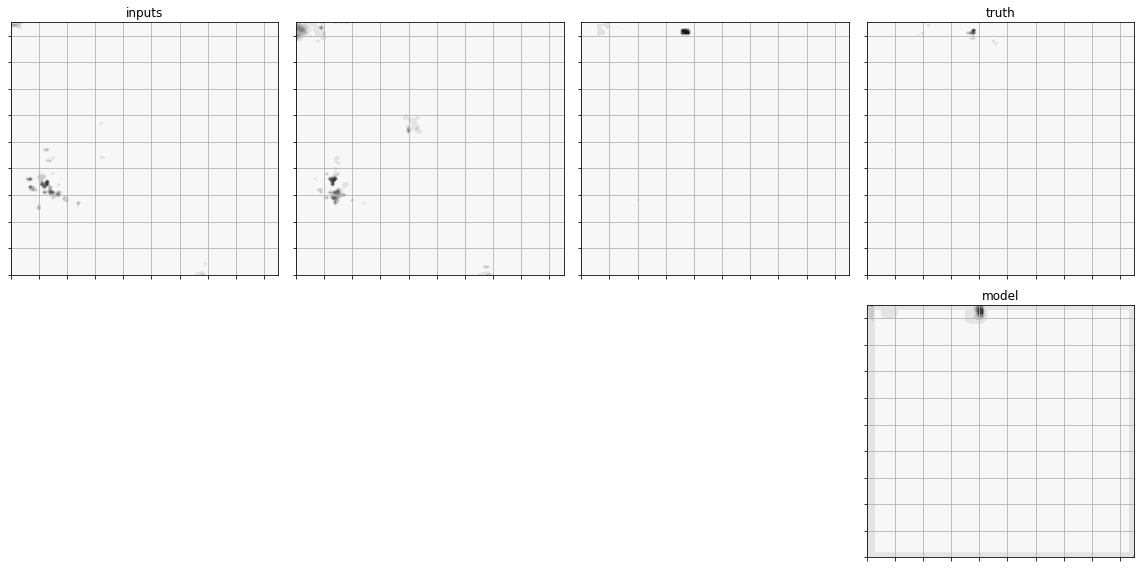

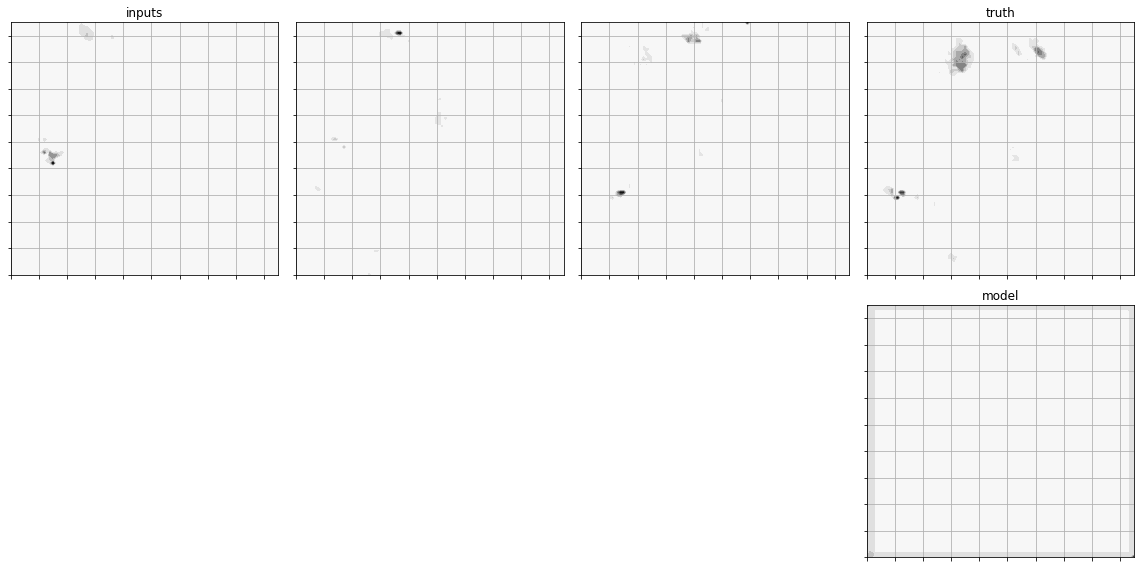

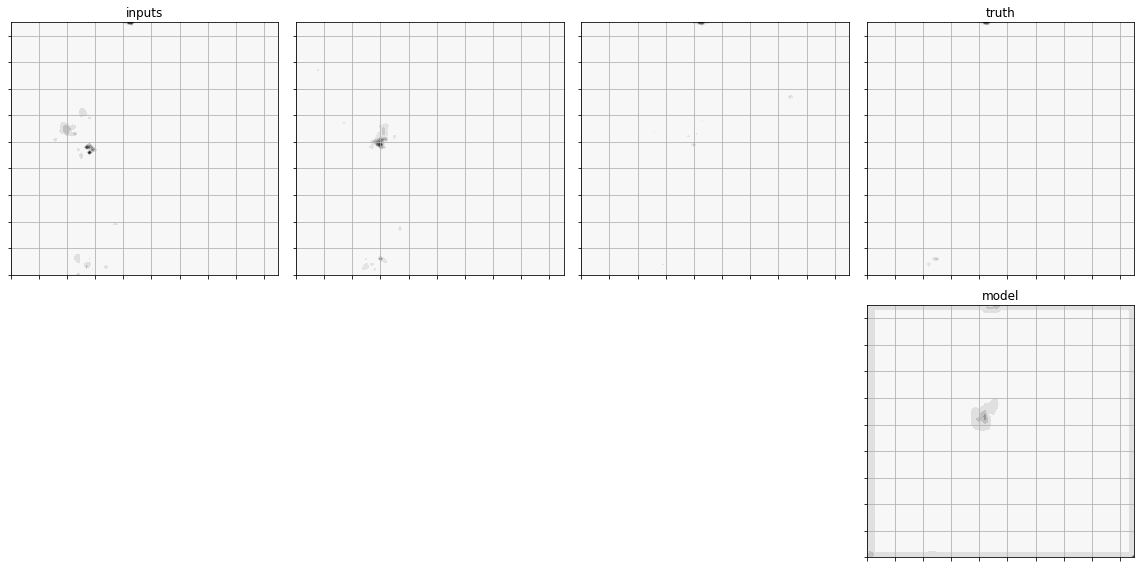

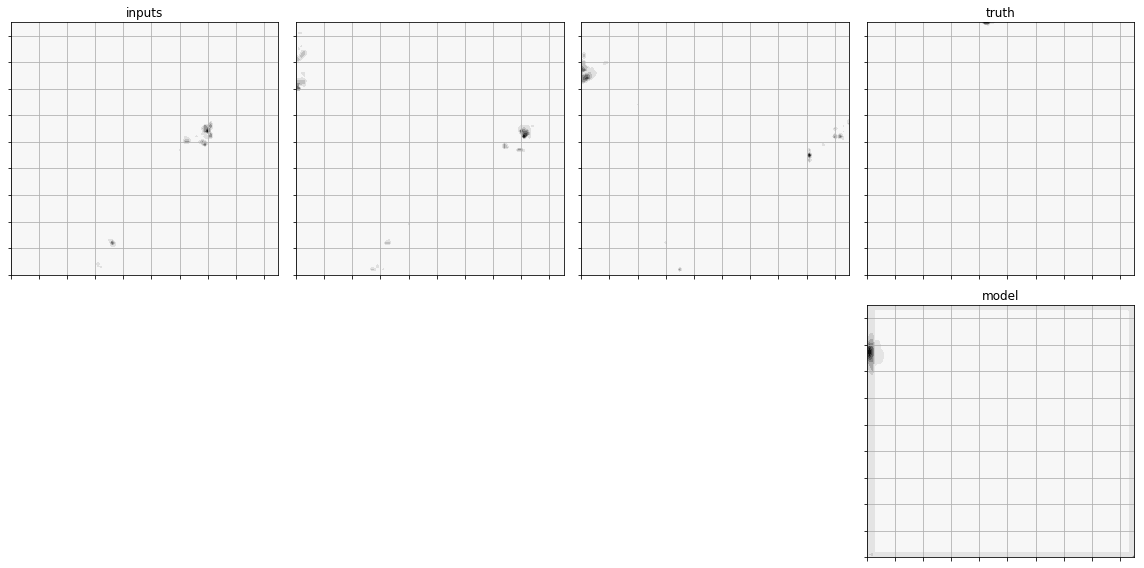

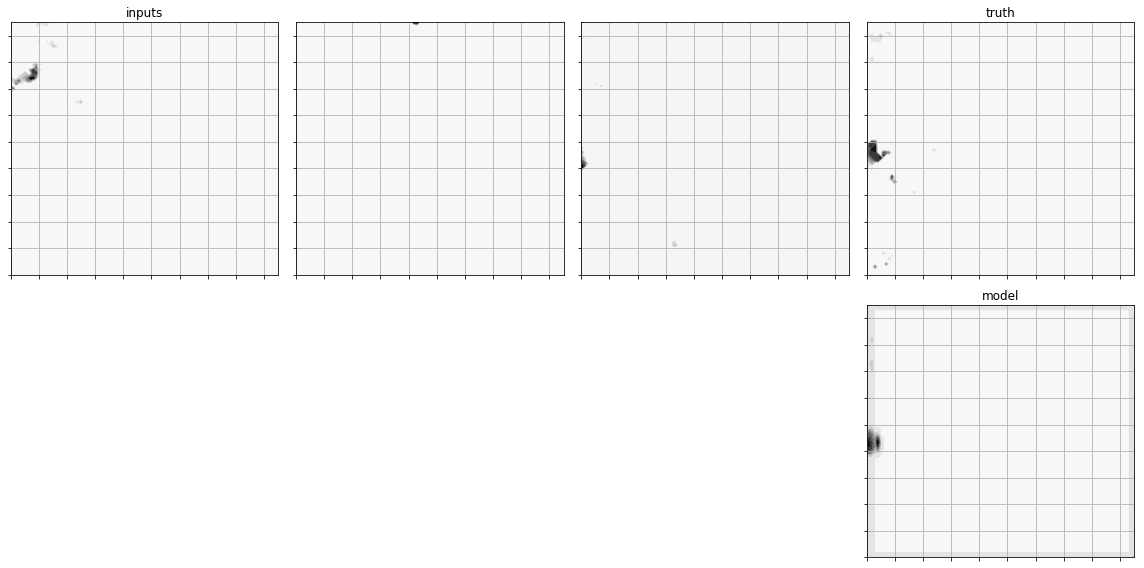

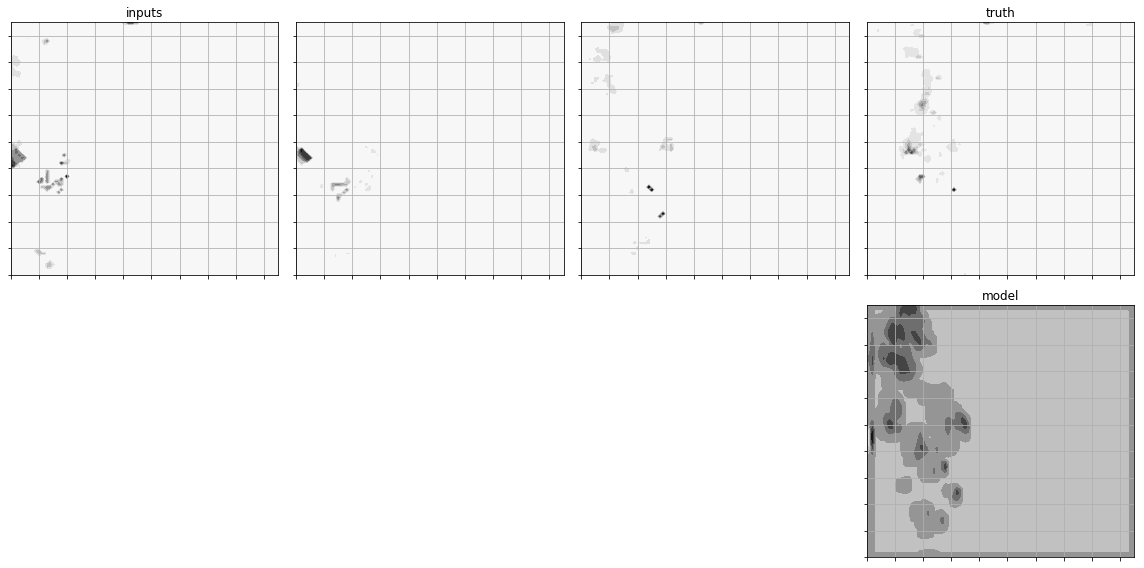

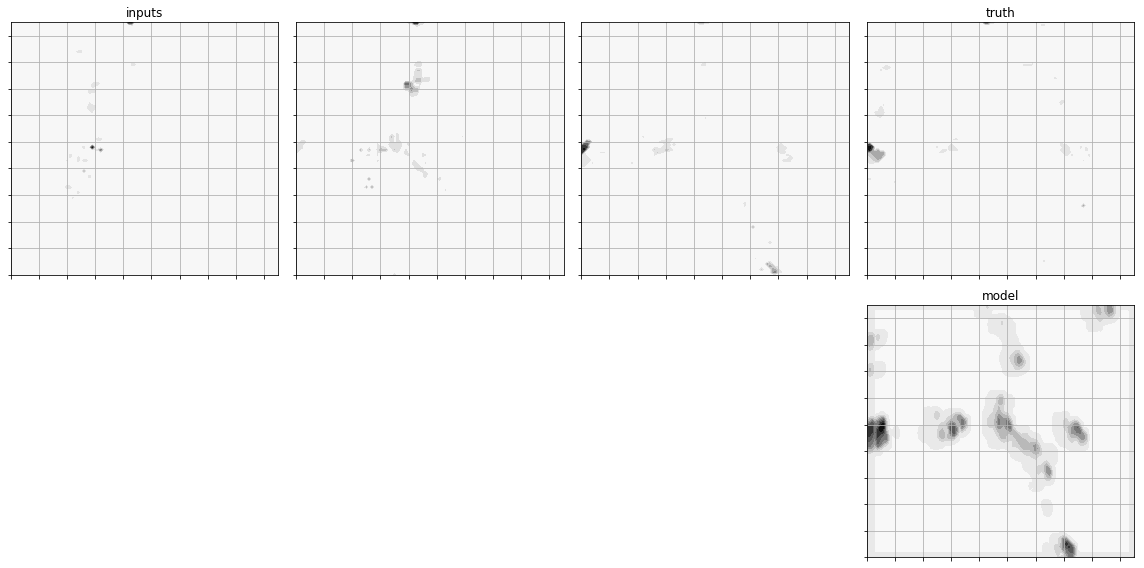

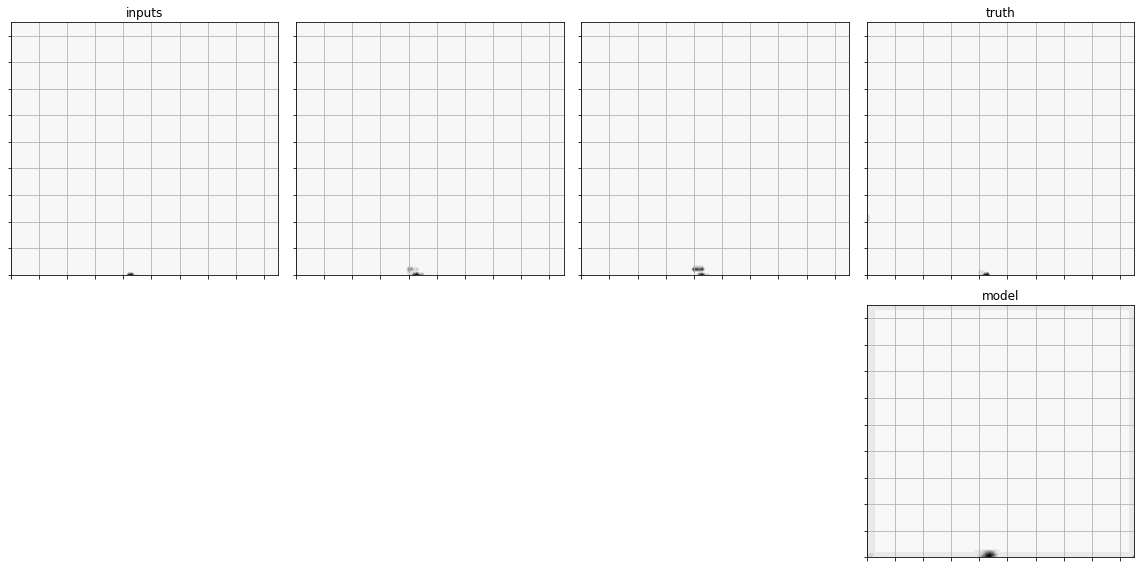

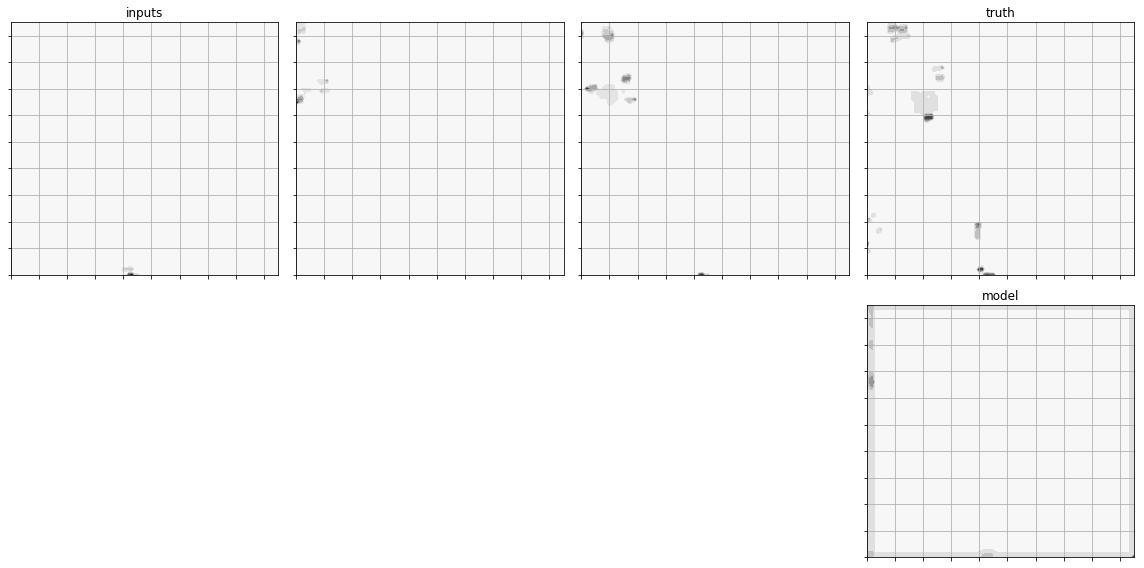

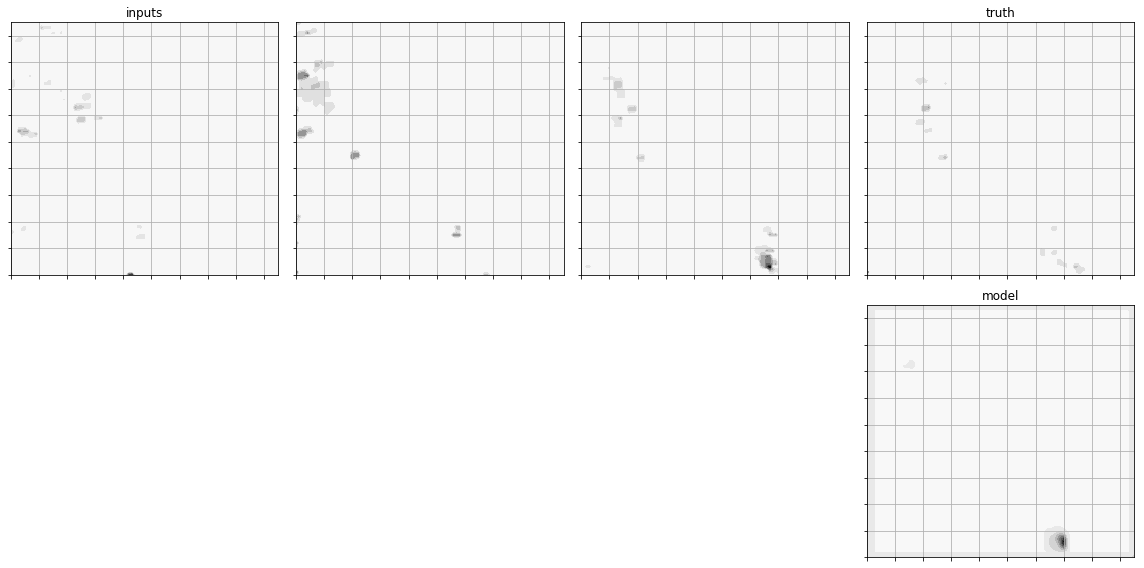

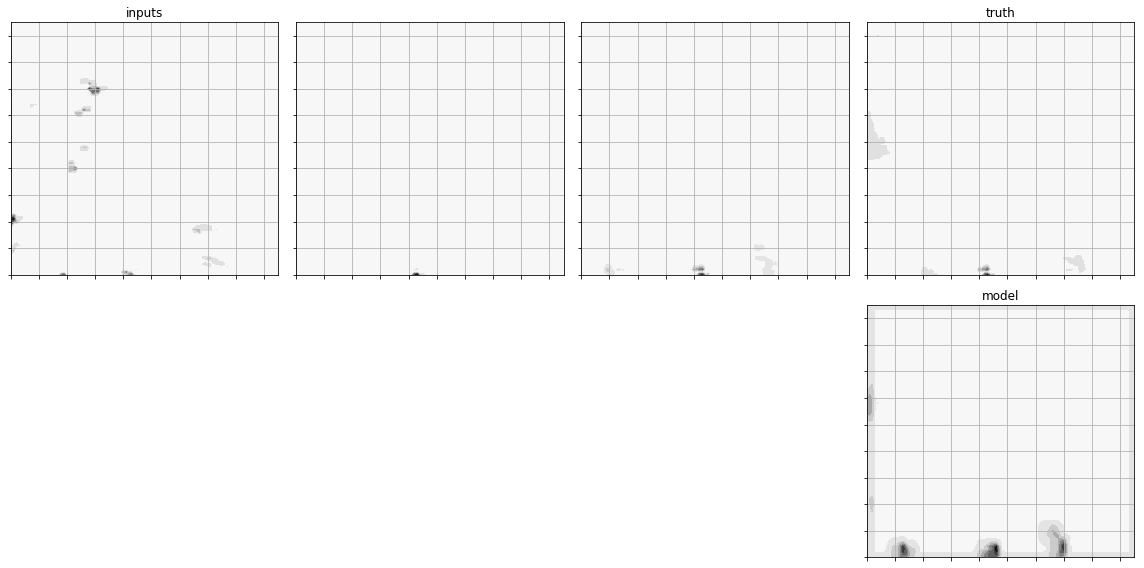

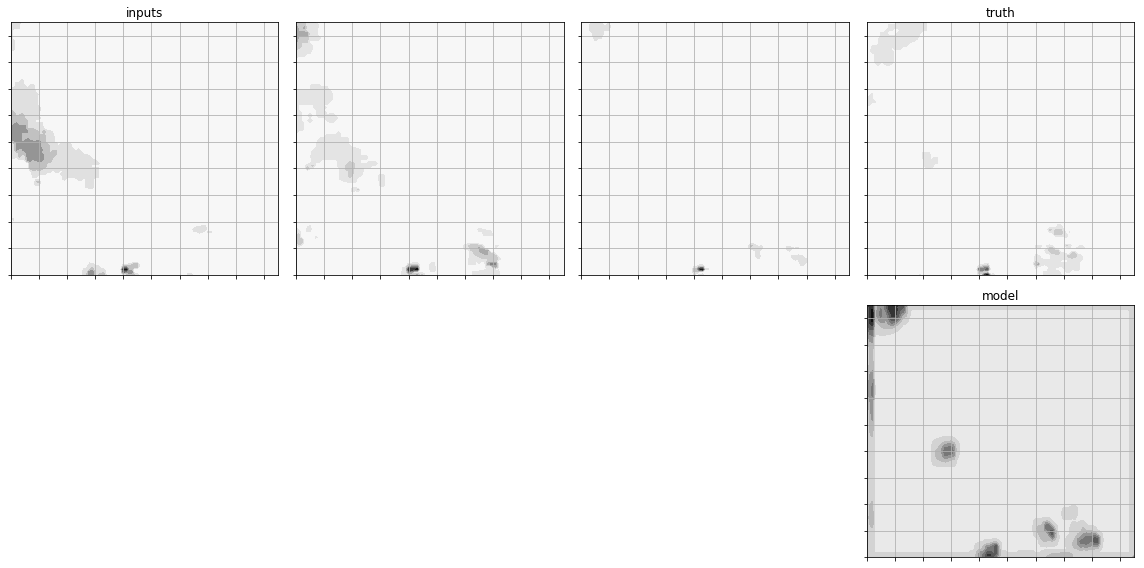

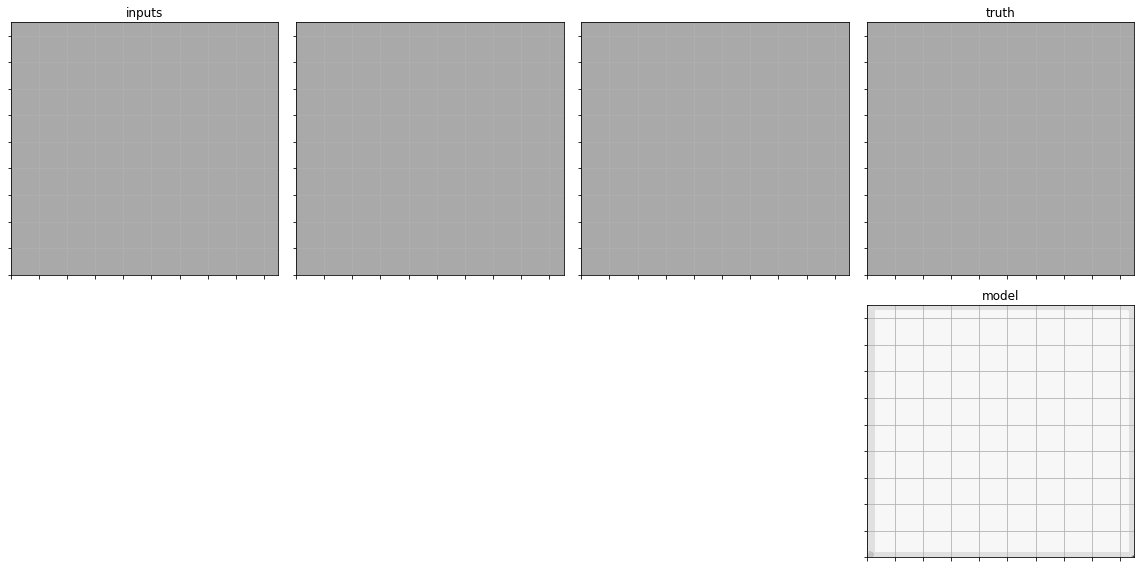

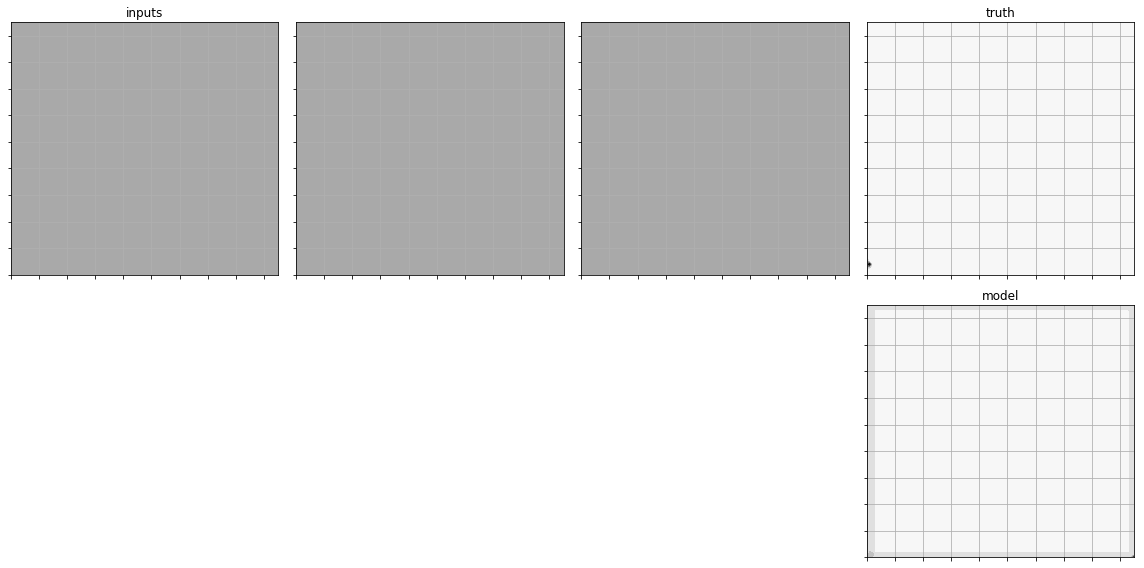

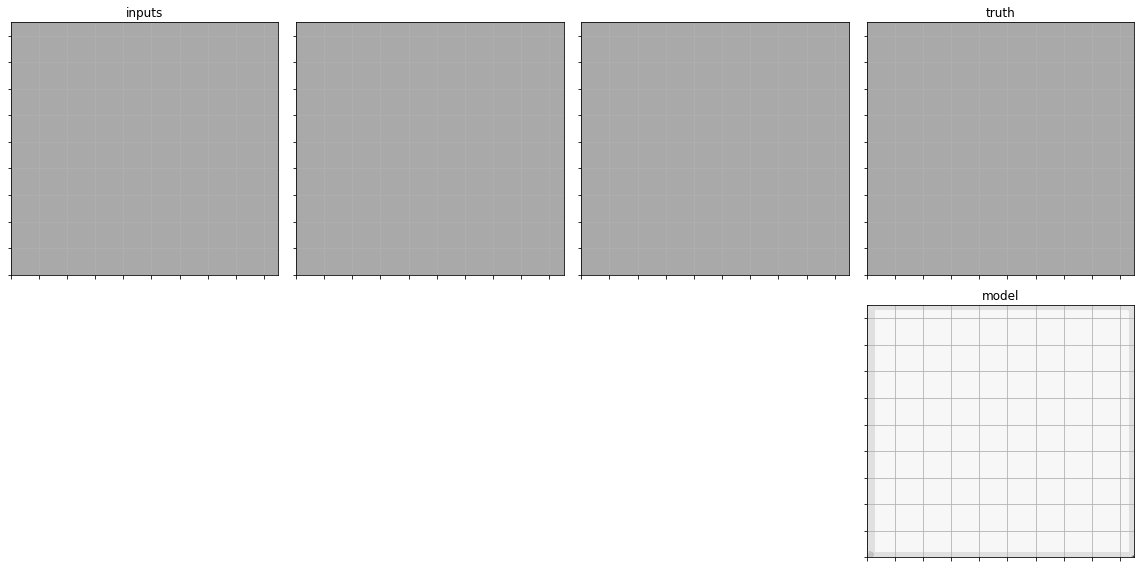

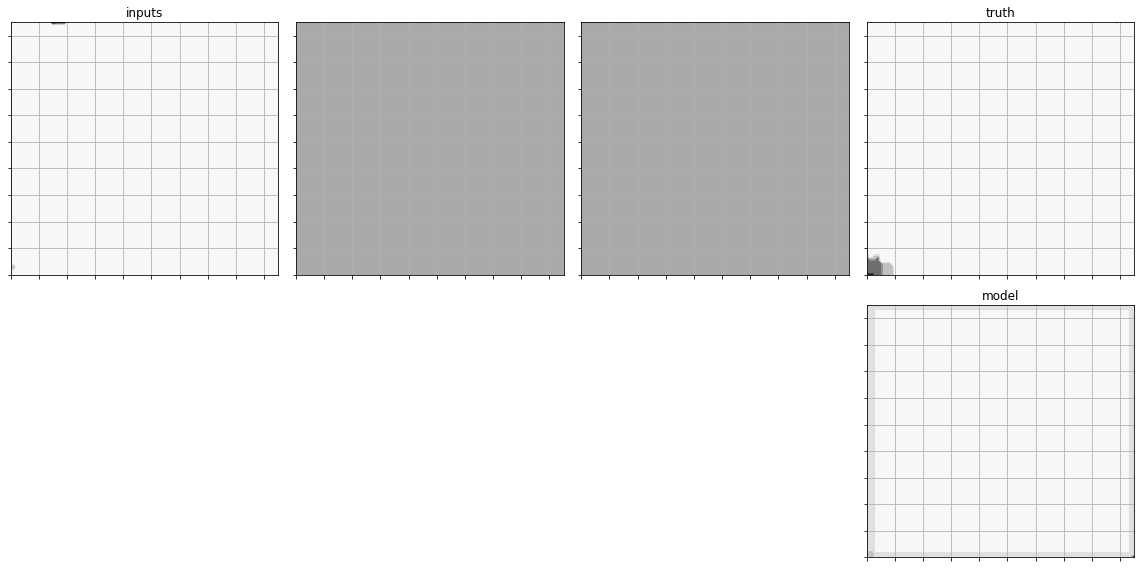

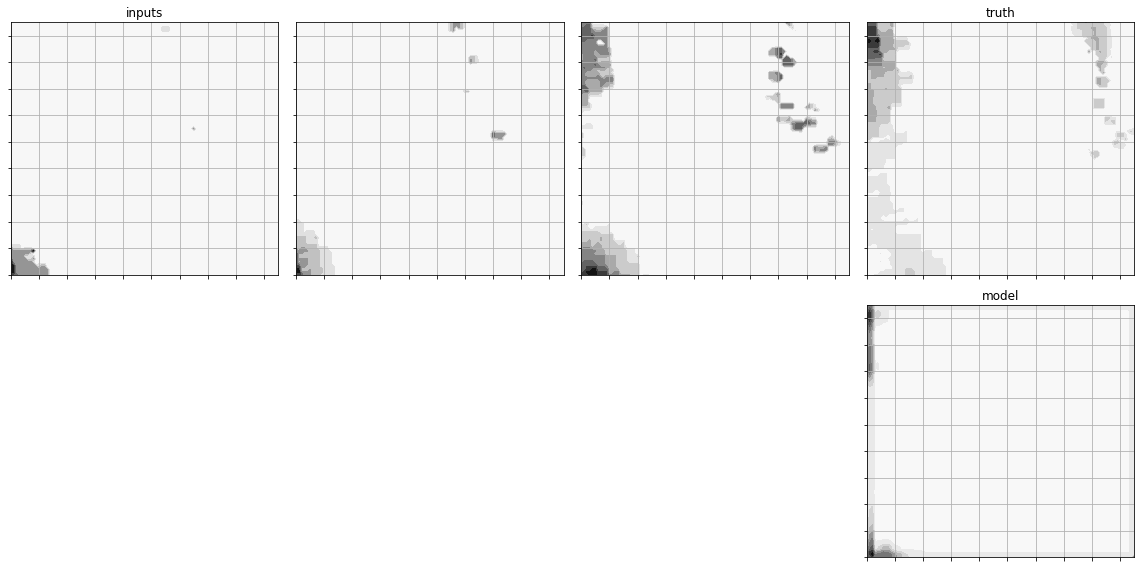

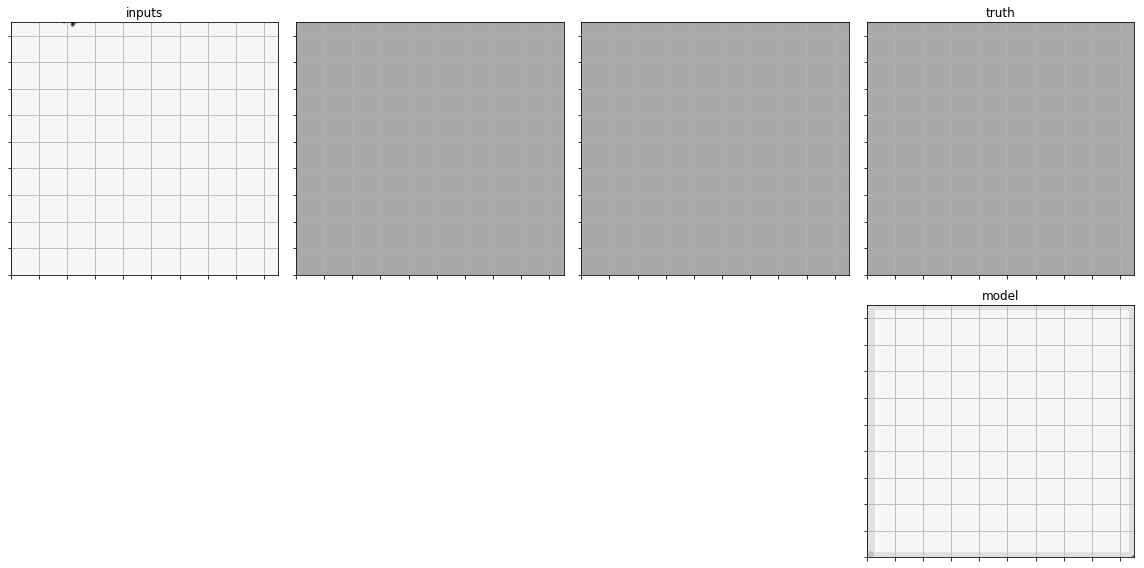

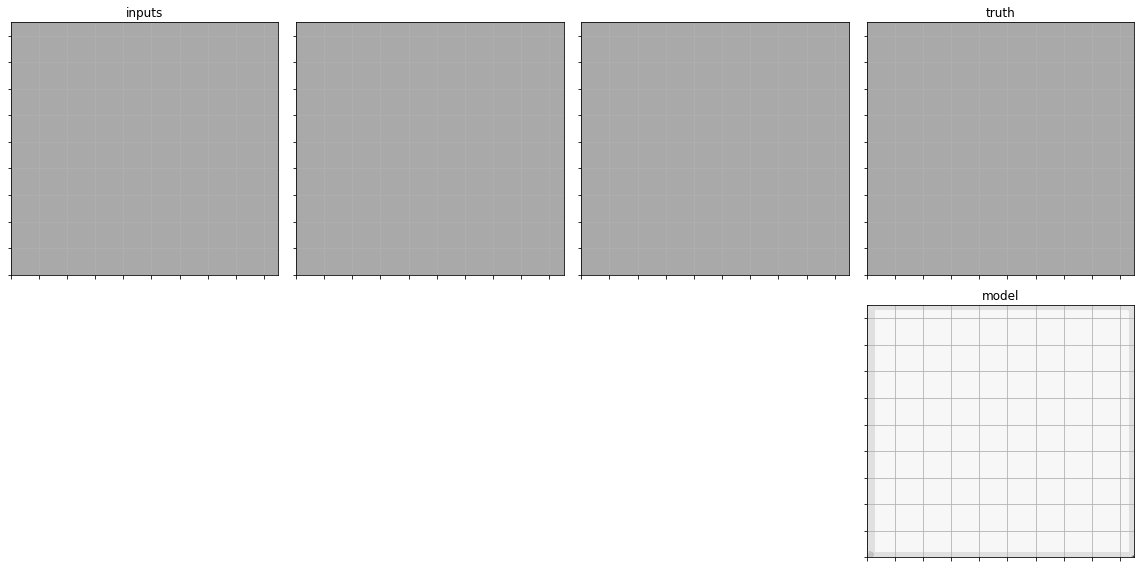

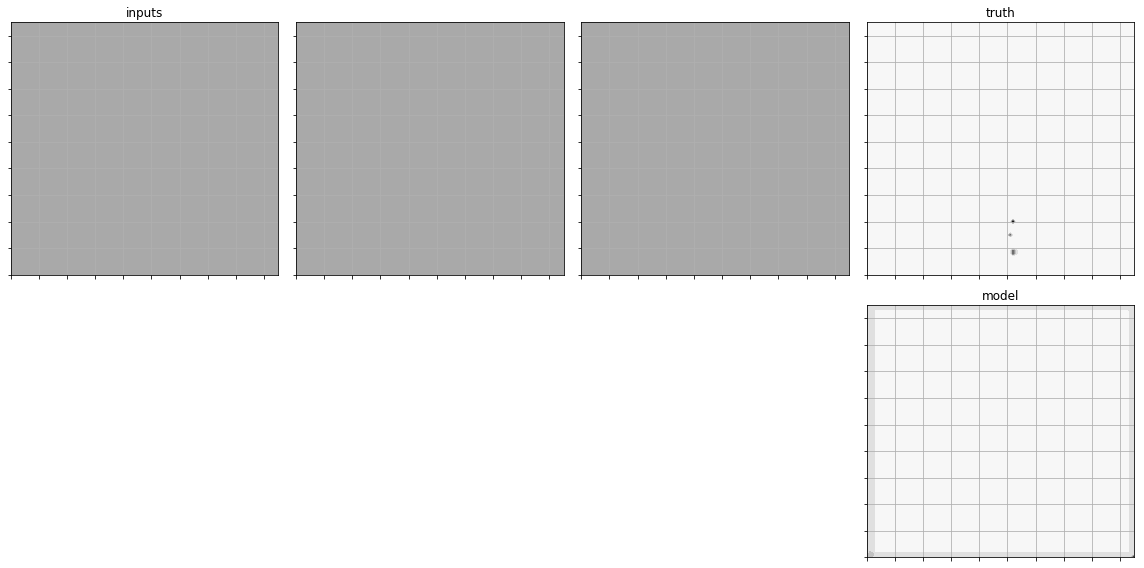

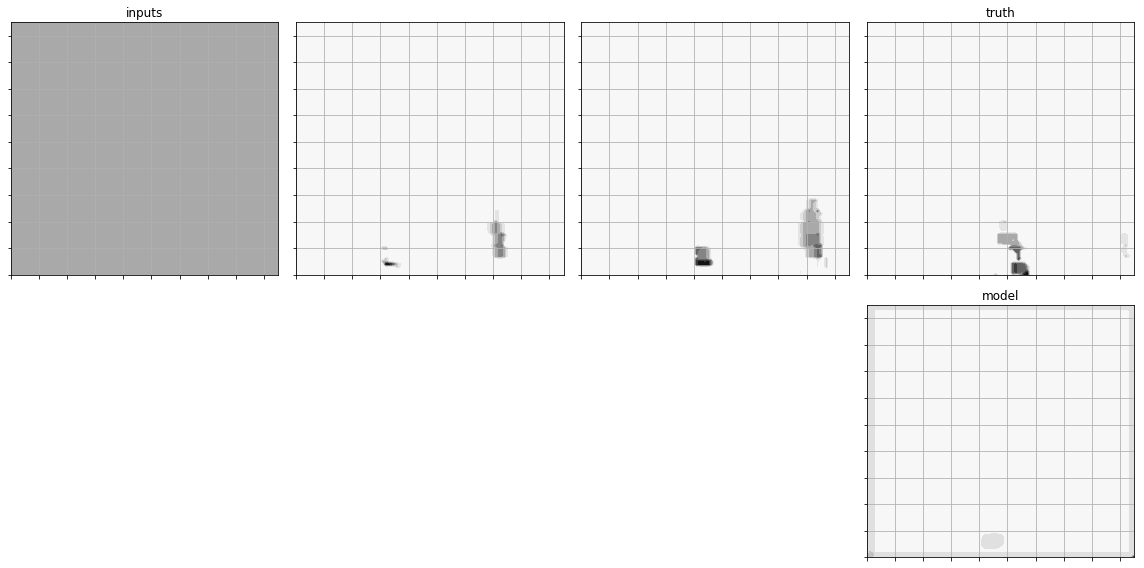

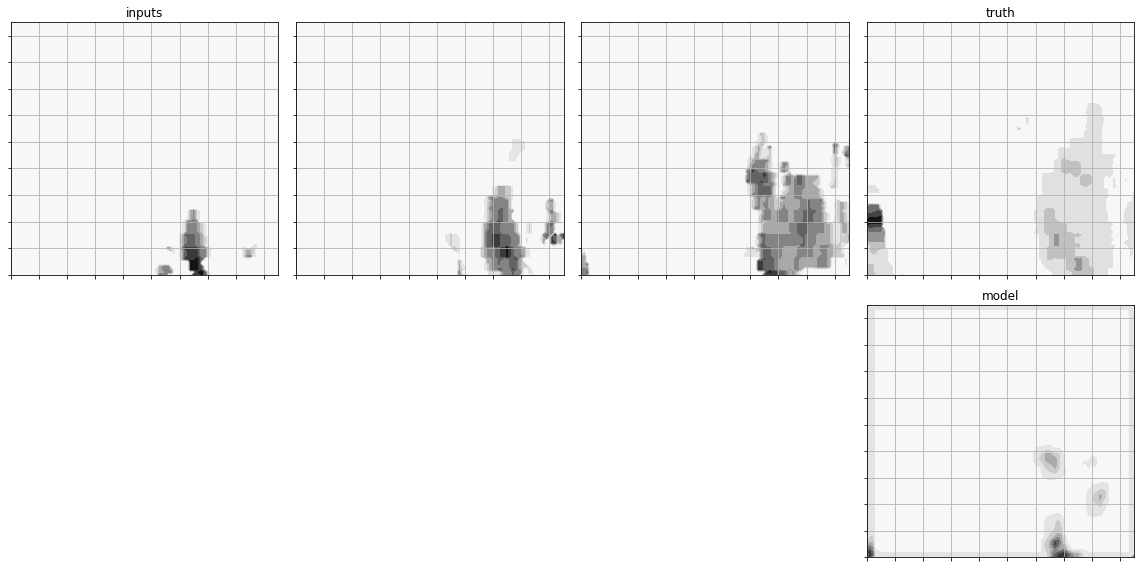

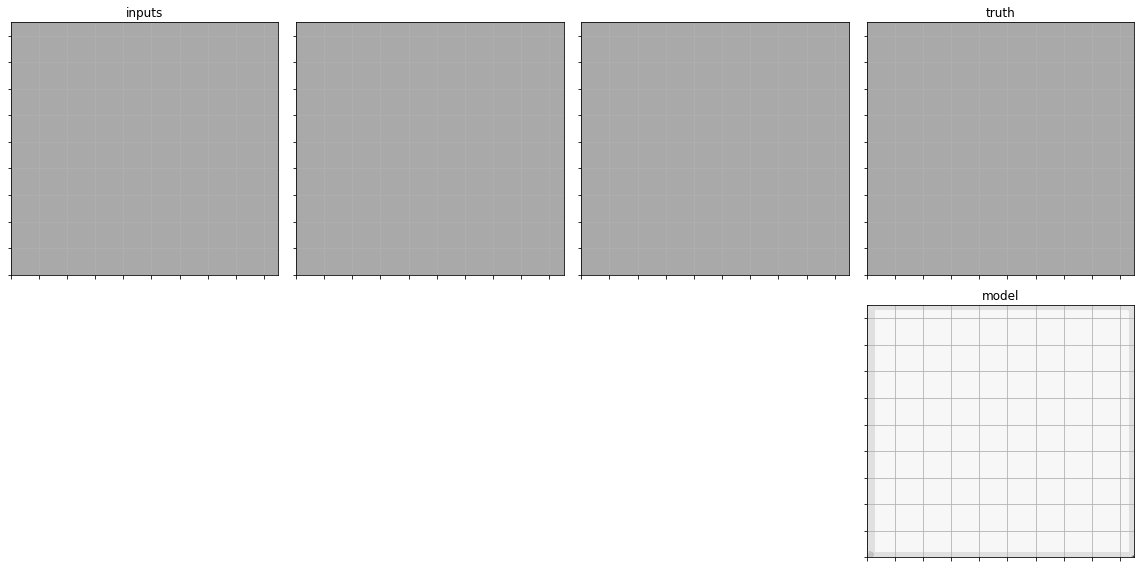

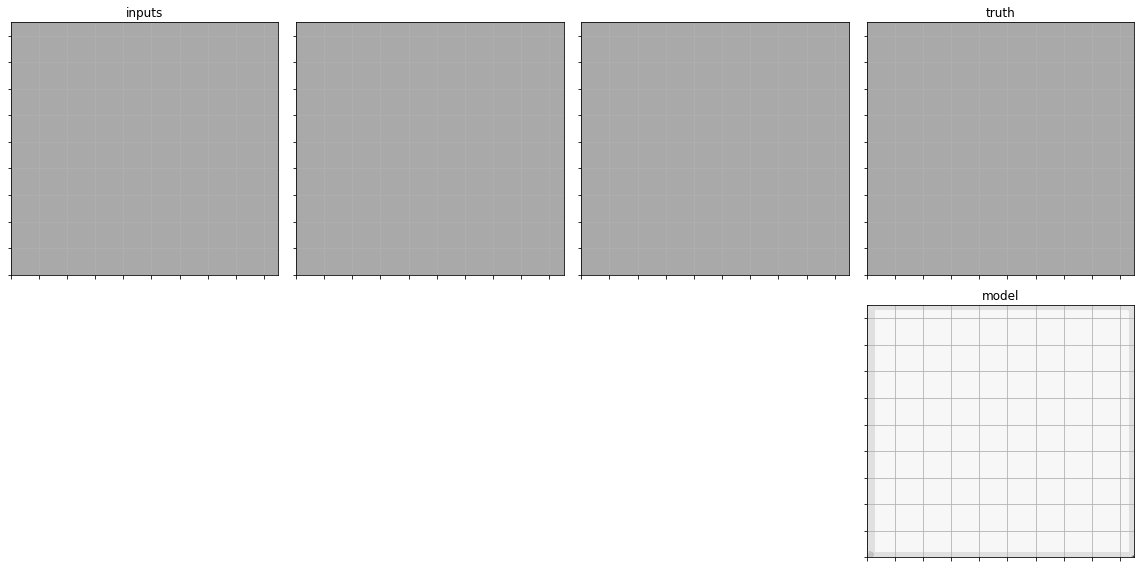

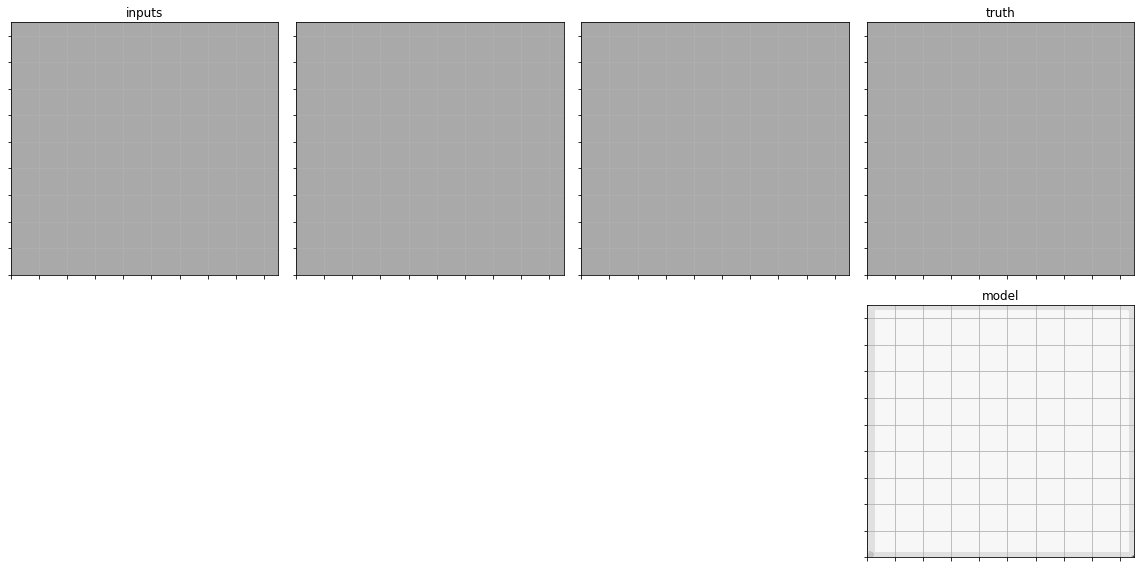

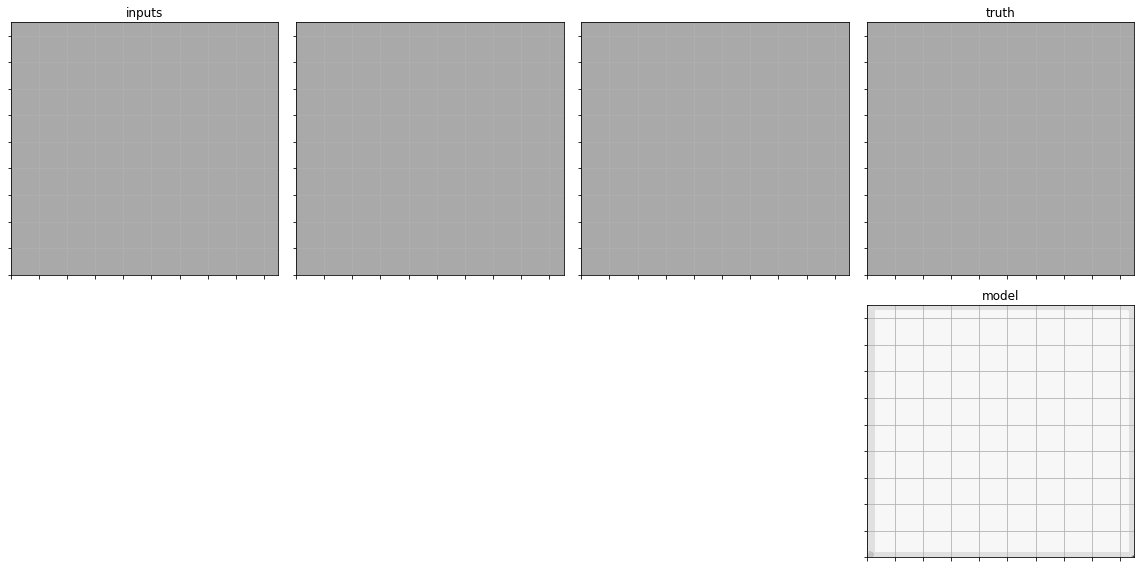

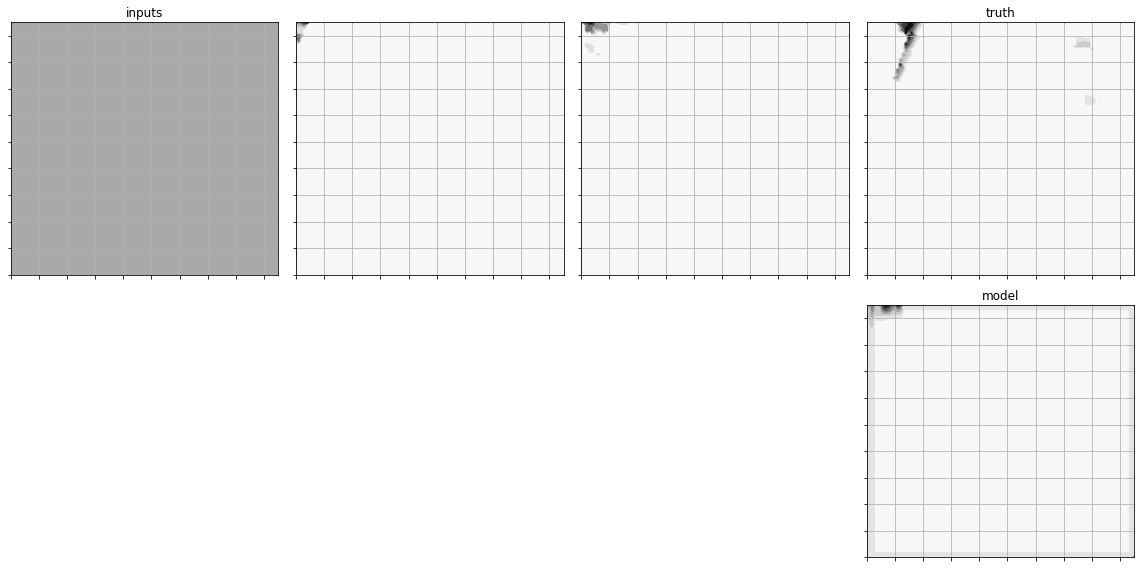

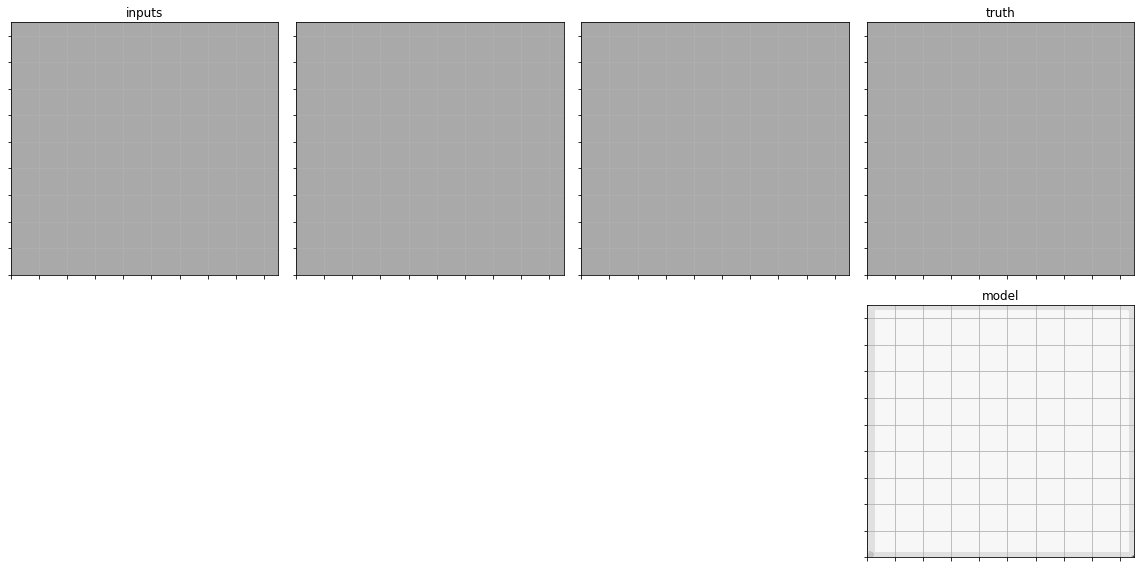

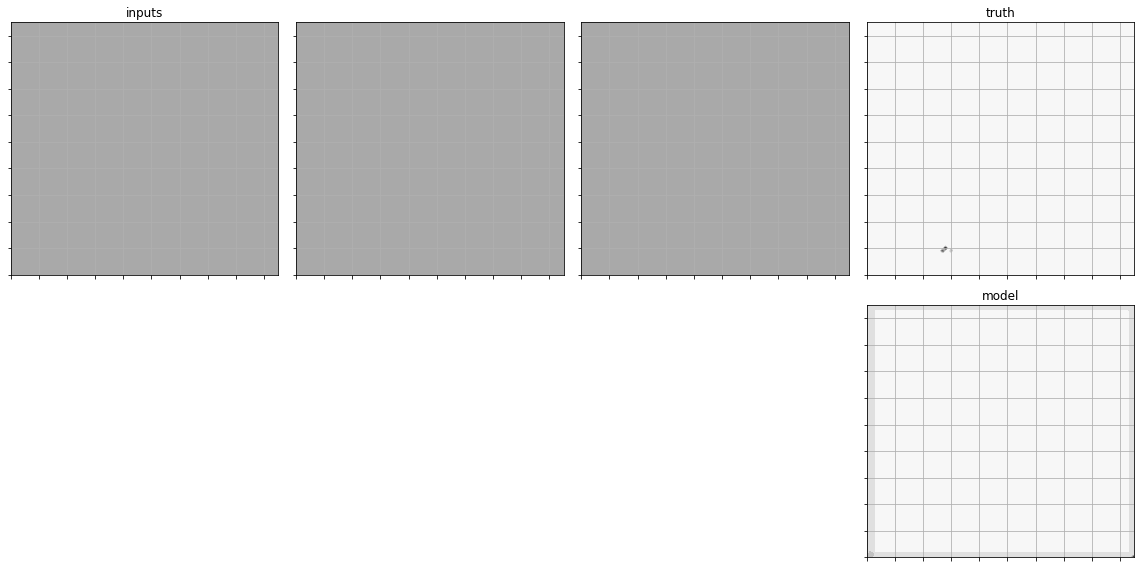

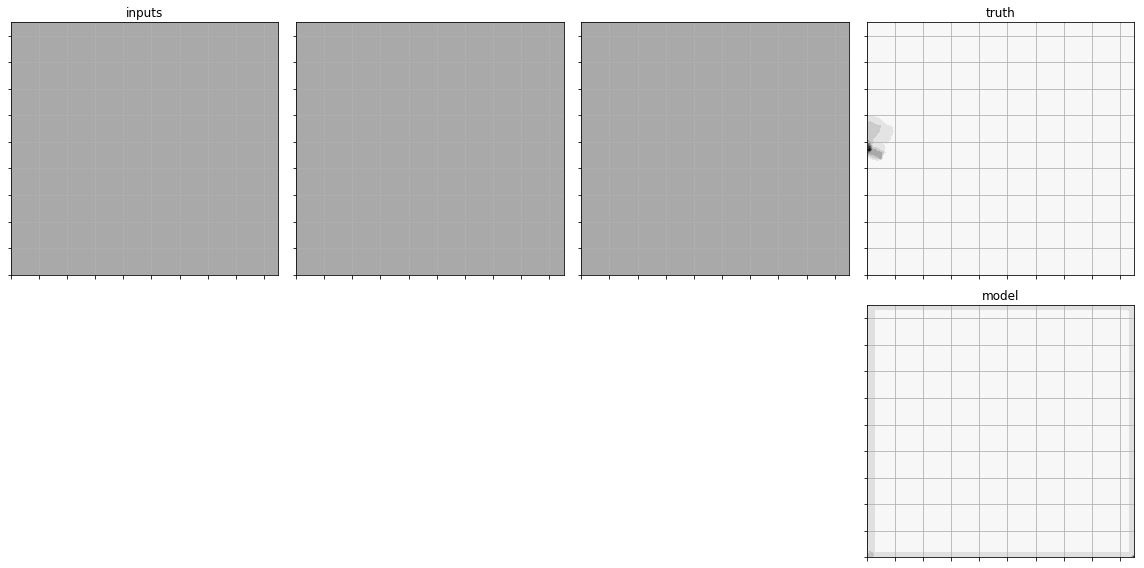

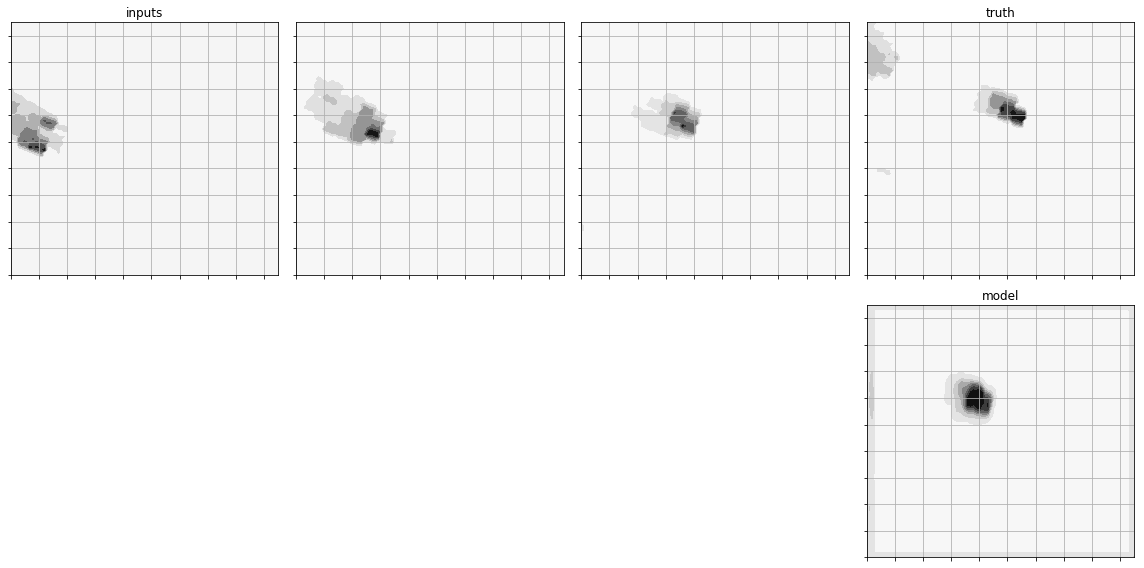

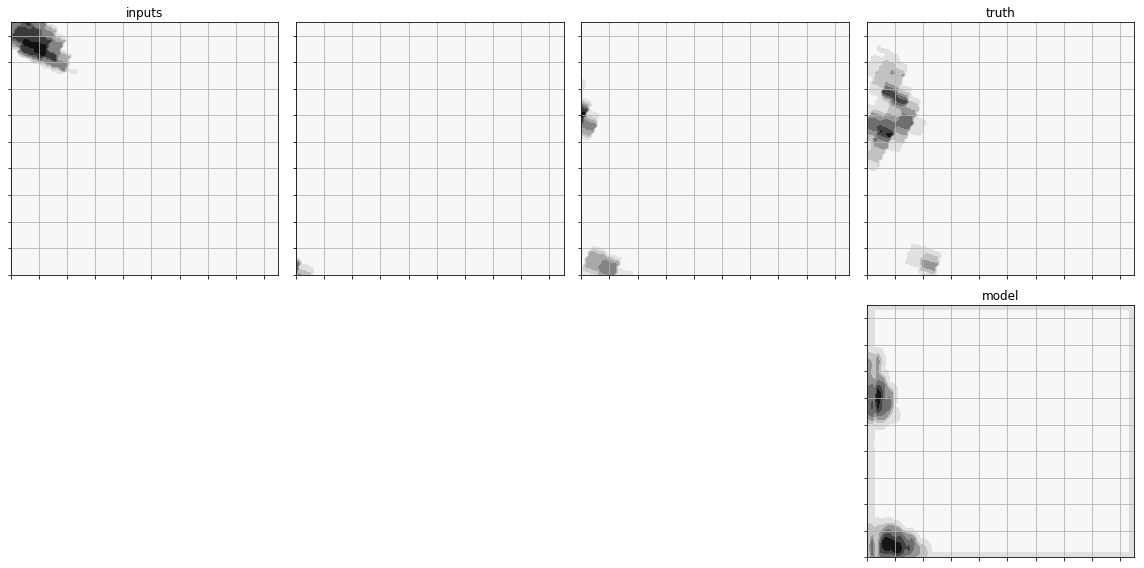

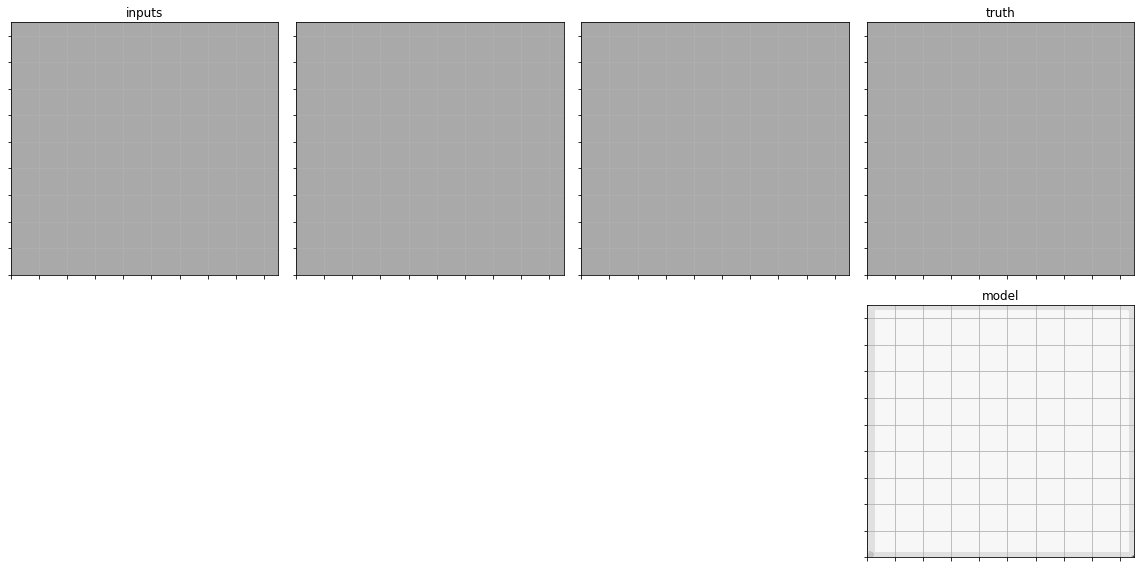

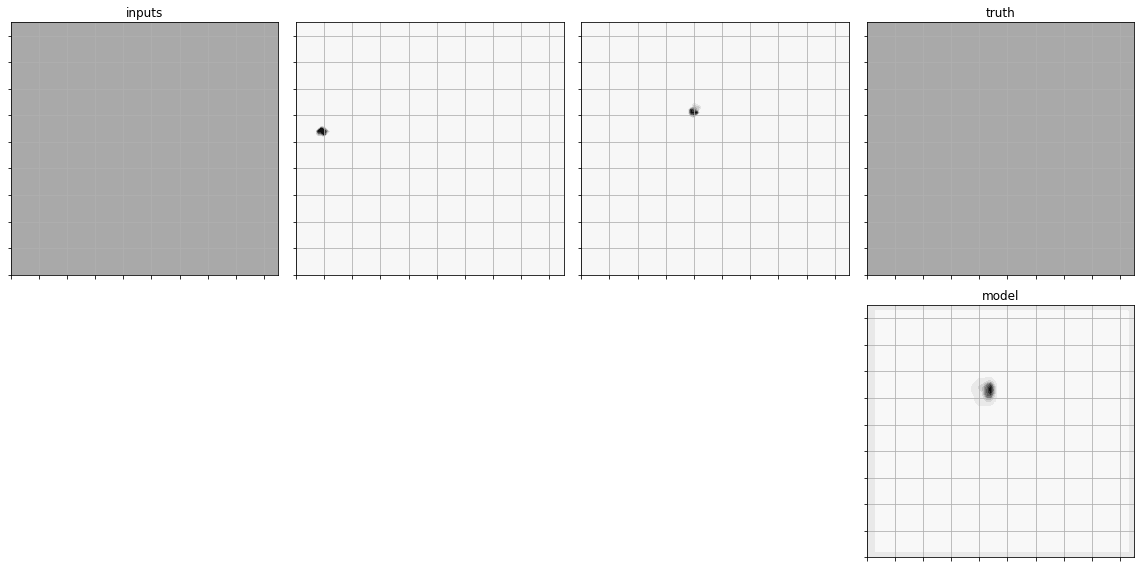

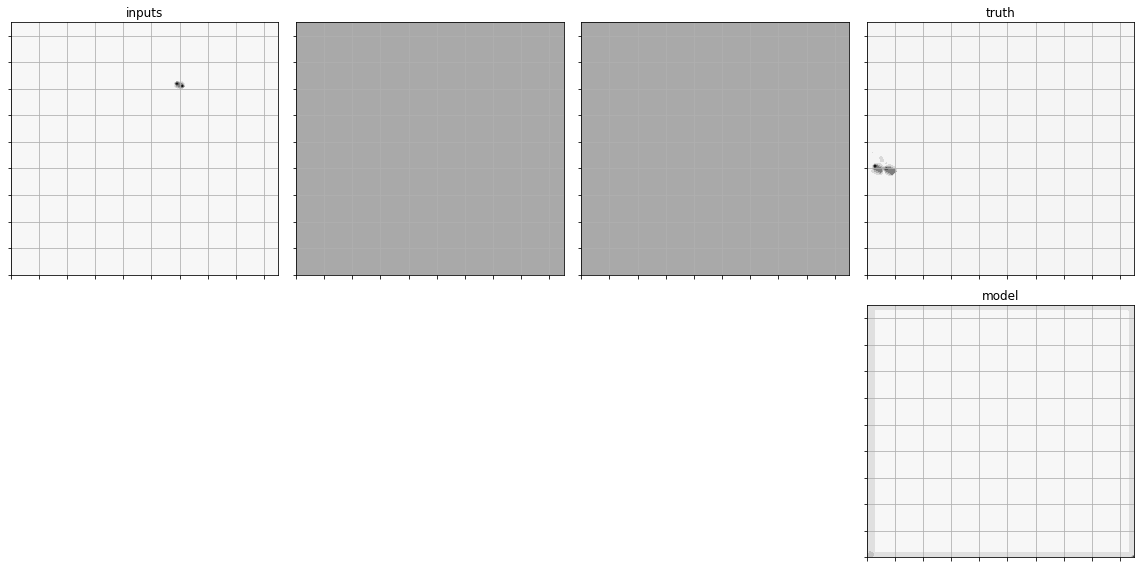

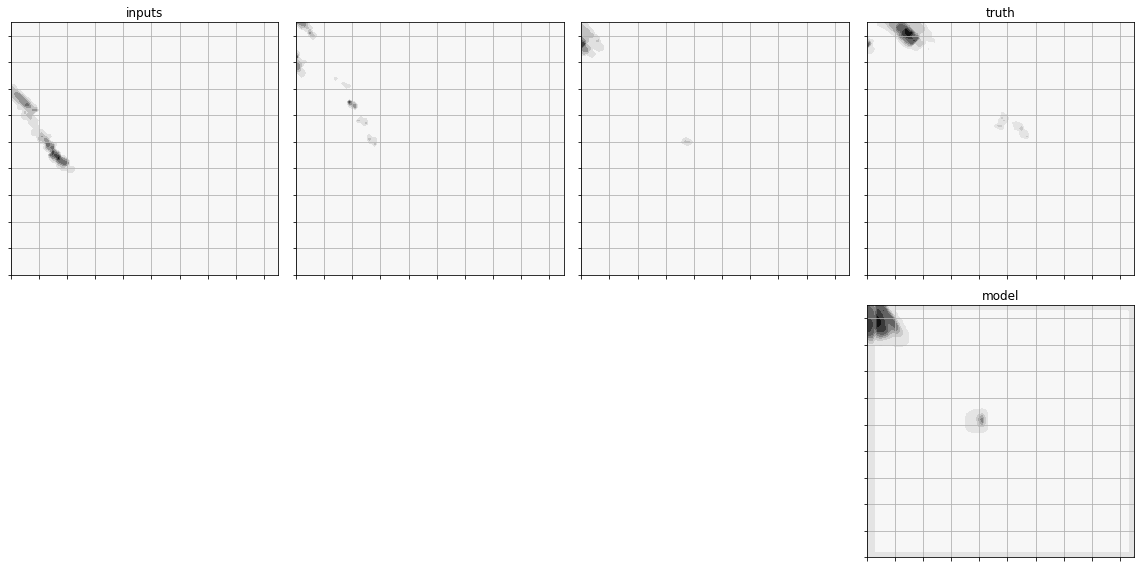

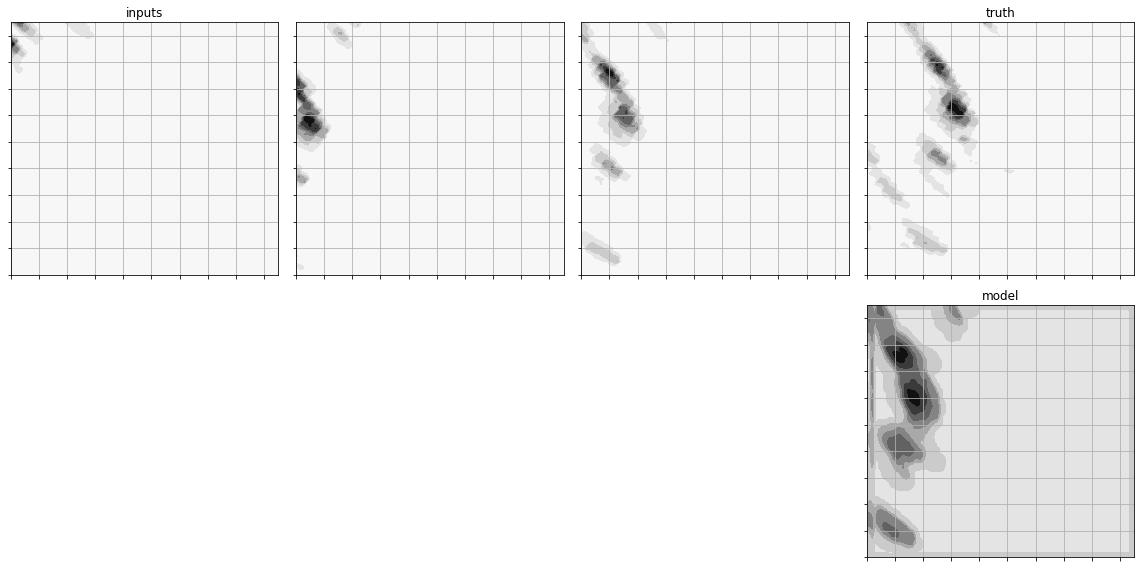

In [15]:
show_outputs(unet, val_loader)

In [ ]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
validation_loss = []
for lr in learning_rates:
    val_loss, len_val_data = train_net(unet, batch_size=10, n_epochs=10, learning_rate=lr)
    validation_loss.append(val_loss)

In [ ]:
n_epochs = [5, 10, 15, 20]
validation_loss_nepochs = []
for epoc in n_epochs:
    val_loss, len_val_data = train_net(unet, batch_size=10, n_epochs=epoc, learning_rate=0.001)
    validation_loss_nepochs.append(val_loss)
    